In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler

import pycountry_convert as pc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data = pd.read_csv('customer_booking.csv', encoding = 'latin-1')
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


Lets perform EDA and see if there is any need for data cleaning

In [3]:
def collect_column_info(df: pd.DataFrame):

    info = {}

    for col in df.columns:

        series = df[col]

        info[col] = {

            'dtype': series.dtype,

            'n_missing': series.isna().sum(),

            'n_unique': series.nunique(dropna=True),

            'sample_values': series.dropna().unique()[:5].tolist()

        }

    return info

eda_dict = collect_column_info(data)

eda_df = pd.DataFrame.from_dict(eda_dict, orient='index')

eda_df

,dtype,n_missing,n_unique,sample_values
num_passengers,int64,0,9,"[2, 1, 3, 4, 6]"
sales_channel,object,0,2,"[Internet, Mobile]"
trip_type,object,0,3,"[RoundTrip, CircleTrip, OneWay]"
purchase_lead,int64,0,470,"[262, 112, 243, 96, 68]"
length_of_stay,int64,0,335,"[19, 20, 22, 31, 48]"
flight_hour,int64,0,24,"[7, 3, 17, 4, 15]"
flight_day,object,0,7,"[Sat, Wed, Thu, Mon, Sun]"
route,object,0,799,"[AKLDEL, AKLHGH, AKLHND, AKLICN, AKLKIX]"
booking_origin,object,0,104,"[New Zealand, India, United Kingdom, China, So..."
wants_extra_baggage,int64,0,2,"[1, 0]"


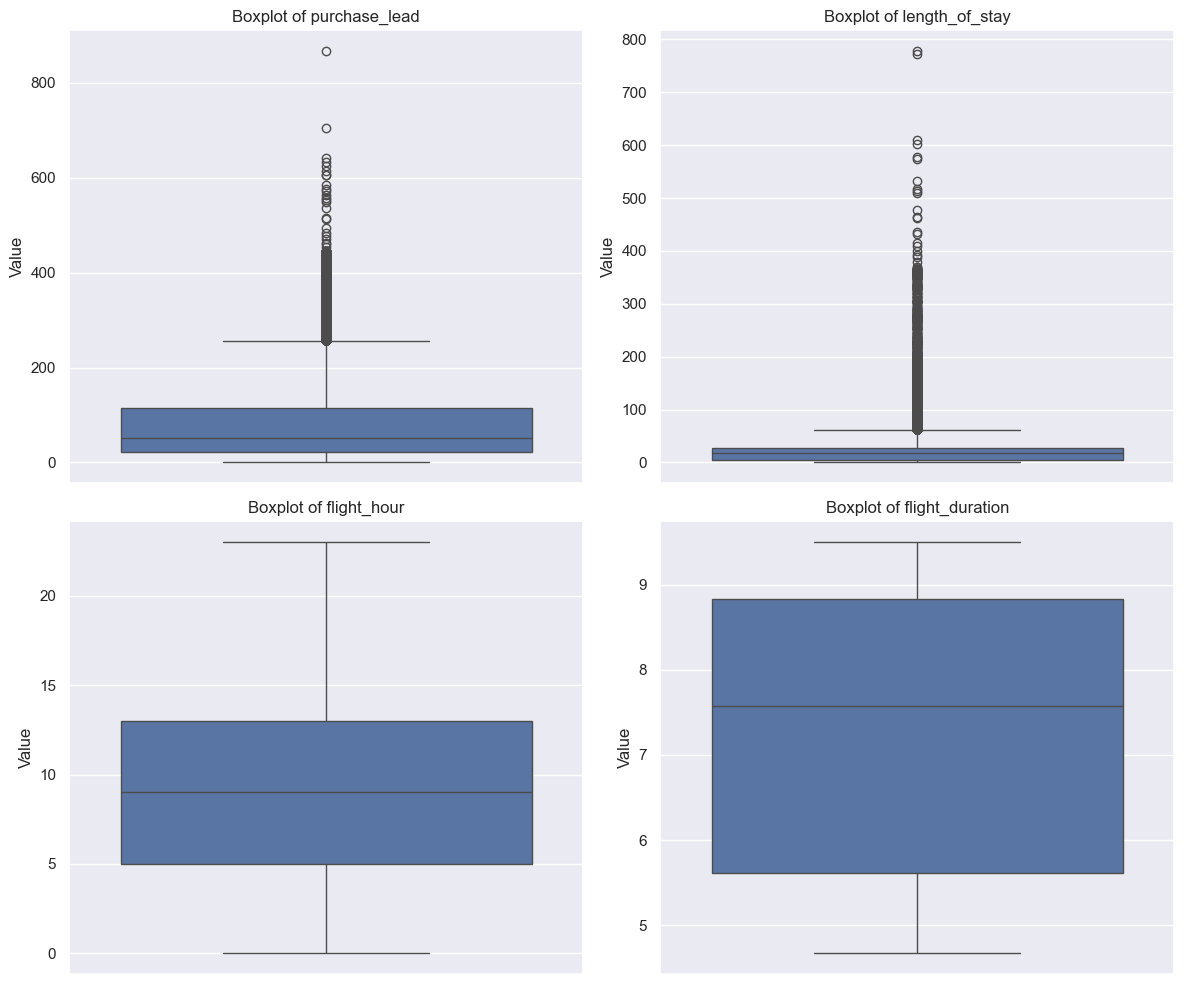

In [4]:
# List of numeric features
numeric_cols = ["purchase_lead", "length_of_stay", "flight_hour", "flight_duration"]

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows x 2 columns

for ax, col in zip(axes.flatten(), numeric_cols):
    sns.boxplot(y=data[col], ax=ax)
    ax.set_title(f"Boxplot of {col}")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()

In [5]:
top_purchase_lead = data.nlargest(5, "purchase_lead")
print("Top 5 rows by purchase_lead:")
top_purchase_lead

Top 5 rows by purchase_lead:


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
48259,3,Internet,RoundTrip,867,6,7,Mon,KIXMLE,Japan,0,0,1,7.00,1
24119,1,Internet,RoundTrip,704,23,8,Tue,PNHSYD,Australia,0,0,0,8.58,0
835,3,Internet,RoundTrip,641,46,6,Sun,AKLKUL,Malaysia,1,0,1,8.83,1
38356,2,Internet,RoundTrip,633,5,10,Sat,HKTOOL,Australia,0,0,1,8.83,0
39417,1,Mobile,RoundTrip,625,5,15,Fri,ICNRGN,Myanmar (Burma),0,0,0,6.62,0


In [6]:
top_length_of_stay = data.nlargest(5, "length_of_stay")
print("\nTop 5 rows by length_of_stay:")
top_length_of_stay


Top 5 rows by length_of_stay:


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
10821,1,Internet,RoundTrip,102,778,8,Wed,DPSMEL,Australia,0,0,0,8.83,1
22081,2,Internet,RoundTrip,11,773,16,Sat,OOLTPE,Taiwan,1,0,1,8.83,0
10294,1,Internet,RoundTrip,10,610,2,Mon,DMKSYD,Australia,1,1,0,8.58,0
1583,2,Internet,RoundTrip,32,603,0,Thu,AKLKUL,Malaysia,0,0,0,8.83,0
24154,1,Internet,RoundTrip,367,577,2,Mon,PNHSYD,Australia,0,0,1,8.58,0


In [7]:
unique_values = data['booking_origin'].unique()
print(unique_values)

['New Zealand' 'India' 'United Kingdom' 'China' 'South Korea' 'Japan'
 'Malaysia' 'Singapore' 'Switzerland' 'Germany' 'Indonesia'
 'Czech Republic' 'Vietnam' 'Thailand' 'Spain' 'Romania' 'Ireland' 'Italy'
 'Slovakia' 'United Arab Emirates' 'Tonga' 'Réunion' '(not set)'
 'Saudi Arabia' 'Netherlands' 'Qatar' 'Hong Kong' 'Philippines'
 'Sri Lanka' 'France' 'Croatia' 'United States' 'Laos' 'Hungary'
 'Portugal' 'Cyprus' 'Australia' 'Cambodia' 'Poland' 'Belgium' 'Oman'
 'Bangladesh' 'Kazakhstan' 'Brazil' 'Turkey' 'Kenya' 'Taiwan' 'Brunei'
 'Chile' 'Bulgaria' 'Ukraine' 'Denmark' 'Colombia' 'Iran' 'Bahrain'
 'Solomon Islands' 'Slovenia' 'Mauritius' 'Nepal' 'Russia' 'Kuwait'
 'Mexico' 'Sweden' 'Austria' 'Lebanon' 'Jordan' 'Greece' 'Mongolia'
 'Canada' 'Tanzania' 'Peru' 'Timor-Leste' 'Argentina' 'New Caledonia'
 'Macau' 'Myanmar (Burma)' 'Norway' 'Panama' 'Bhutan' 'Norfolk Island'
 'Finland' 'Nicaragua' 'Maldives' 'Egypt' 'Israel' 'Tunisia'
 'South Africa' 'Papua New Guinea' 'Paraguay' 'Estonia

In [8]:
# Filter rows where booking_origin is '(not set)' or 'Réunion'
filtered_rows = data[data['booking_origin'].isin(['(not set)'])]

# Display the result
print(filtered_rows)

# Count occurrences of '(not set)' and 'Réunion'
counts = data['booking_origin'].value_counts().loc['(not set)']
print(counts)

       num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
252                 2      Internet  RoundTrip             14              17   
1147                3      Internet  RoundTrip             40              17   
4547                1      Internet  RoundTrip             29              38   
6311                2      Internet  RoundTrip            197              42   
6518                2      Internet  RoundTrip            248              24   
...               ...           ...        ...            ...             ...   
45921               2      Internet  RoundTrip             60               6   
46007               1      Internet  RoundTrip            163               6   
46043               1      Internet  RoundTrip              5               6   
46847               1      Internet  RoundTrip             46               6   
49430               1      Internet  RoundTrip             34               6   

       flight_hour flight_d

In [9]:
# Remove rows where booking_origin is '(not set)'
data = data[data['booking_origin'] != '(not set)']

# (optional) reset index after removal
data = data.reset_index(drop=True)

<Axes: >

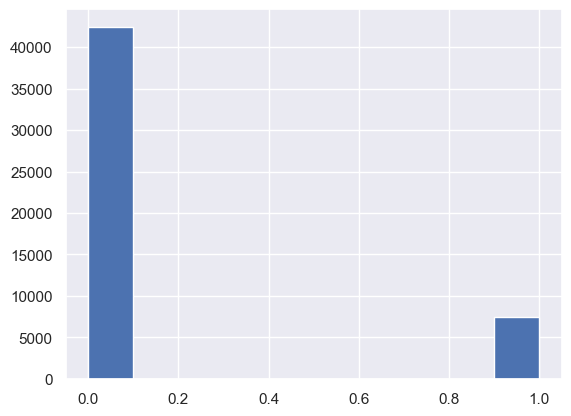

In [10]:
data['booking_complete'].hist()

We will drop "route" which contains 799 unique labels.

We will use one hot encoding for "sales_channel", "trip_type". For "flight_day" we will use cyclical encoding (sine / cosine) since flight patterns may differ on weekends vs. weekdays, and the model knows Sunday is next to Monday. This does not affect performance for Tree-based models so much (RandomForest, XGBoost, LightGBM), but it does for Linear models / Neural nets.

We will create a new category named "region" where it will replace "booking_origin", since this column contains 104 unique values.

The values in our target variable are un balanced, this can affect our ML model. We should makes sure our train data is balanced. Test data should be skewed to reflect a real world scenario.

### Lets Group Booking Origin, based on each countries Region
The performance does not change that much if we include Region rather than droping the booking_originals column

In [11]:
# def country_to_region(country):
#     try:
#         if country in ["(not set)", None, np.nan]:
#             return "Other"
#         if country in ["Hong Kong", "Macau"]:
#             return "Asia"
#         if country == "Réunion":
#             return "Africa"
#         if country == "New Caledonia" or country == "Norfolk Island":
#             return "Oceania"
#         if country == "Svalbard & Jan Mayen":
#             return "Europe"
#         if country == "Czechia":
#             country = "Czech Republic"
#         if country == "Myanmar (Burma)":
#             country = "Myanmar"

#         country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
#         continent_code = pc.country_alpha2_to_continent_code(country_code)
#         continent_map = {
#             "AF": "Africa",
#             "AS": "Asia",
#             "EU": "Europe",
#             "NA": "North America",
#             "SA": "South America",
#             "OC": "Oceania",
#         }
#         return continent_map.get(continent_code, "Other")
#     except:
#         return "Other"   # always a string

### Lets Group Booking Origin, based on each countries GDP per capita,to Tier 1, Tier 2 and Tier 3 countries
This yields better results than region

In [12]:
country_tier_map = {
    # Tier 1 Countries (GDP PPP per capita > $40,000)
    'Australia': 'Tier 1',
    'Austria': 'Tier 1',
    'Belgium': 'Tier 1',
    'Brunei': 'Tier 1',
    'Canada': 'Tier 1',
    'Cyprus': 'Tier 1',
    'Czech Republic': 'Tier 1',
    'Czechia': 'Tier 1',  # Alternative name
    'Denmark': 'Tier 1',
    'Estonia': 'Tier 1',
    'Finland': 'Tier 1',
    'France': 'Tier 1',
    'Germany': 'Tier 1',
    'Hong Kong': 'Tier 1',
    'Ireland': 'Tier 1',
    'Israel': 'Tier 1',
    'Italy': 'Tier 1',
    'Japan': 'Tier 1',
    'Kuwait': 'Tier 1',
    'Malta': 'Tier 1',
    'Netherlands': 'Tier 1',
    'New Zealand': 'Tier 1',
    'Norway': 'Tier 1',
    'Oman': 'Tier 1',
    'Poland': 'Tier 1',
    'Portugal': 'Tier 1',
    'Qatar': 'Tier 1',
    'Saudi Arabia': 'Tier 1',
    'Singapore': 'Tier 1',
    'Slovakia': 'Tier 1',
    'Slovenia': 'Tier 1',
    'South Korea': 'Tier 1',
    'Spain': 'Tier 1',
    'Sweden': 'Tier 1',
    'Switzerland': 'Tier 1',
    'Taiwan': 'Tier 1',
    'United Arab Emirates': 'Tier 1',
    'United Kingdom': 'Tier 1',
    'United States': 'Tier 1',
    
    # Tier 2 Countries (GDP PPP per capita $15,000–$40,000)
    'Argentina': 'Tier 2',
    'Bahrain': 'Tier 2',
    'Brazil': 'Tier 2',
    'Bulgaria': 'Tier 2',
    'Chile': 'Tier 2',
    'China': 'Tier 2',
    'Croatia': 'Tier 2',
    'Greece': 'Tier 2',
    'Hungary': 'Tier 2',
    'Kazakhstan': 'Tier 2',
    'Malaysia': 'Tier 2',
    'Mauritius': 'Tier 2',
    'Mexico': 'Tier 2',
    'Panama': 'Tier 2',
    'Romania': 'Tier 2',
    'Russia': 'Tier 2',
    'Seychelles': 'Tier 2',
    'Turkey': 'Tier 2',
    'Uruguay': 'Tier 2',
    
    # Tier 3 Countries (GDP PPP per capita < $15,000)
    'Afghanistan': 'Tier 3',
    'Algeria': 'Tier 3',
    'Bangladesh': 'Tier 3',
    'Belarus': 'Tier 3',
    'Bhutan': 'Tier 3',
    'Cambodia': 'Tier 3',
    'Colombia': 'Tier 3',
    'Egypt': 'Tier 3',
    'Ghana': 'Tier 3',
    'Guam': 'Tier 3',
    'Guatemala': 'Tier 3',
    'India': 'Tier 3',
    'Indonesia': 'Tier 3',
    'Iran': 'Tier 3',
    'Iraq': 'Tier 3',
    'Jordan': 'Tier 3',
    'Kenya': 'Tier 3',
    'Laos': 'Tier 3',
    'Mongolia': 'Tier 3',
    'Nepal': 'Tier 3',
    'Nicaragua': 'Tier 3',
    'Pakistan': 'Tier 3',
    'Paraguay': 'Tier 3',
    'Philippines': 'Tier 3',
    'Réunion': 'Tier 3',
    'South Africa': 'Tier 3',
    'Sri Lanka': 'Tier 3',
    'Tanzania': 'Tier 3',
    'Thailand': 'Tier 3',
    'Timor-Leste': 'Tier 3',
    'Tunisia': 'Tier 3',
    'Ukraine': 'Tier 3',
    'Vietnam': 'Tier 3',
    
    # Special Cases (based on regional economic data)
    'Macau': 'Tier 1',
    'New Caledonia': 'Tier 2',
    'Norfolk Island': 'Tier 2',  # Assuming similar to Australia
    'Svalbard & Jan Mayen': 'Tier 1',  # Norwegian territory
    'Tonga': 'Tier 3',
    'Myanmar (Burma)': 'Tier 3'
}

In [13]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import RobustScaler
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from scipy.spatial.distance import cdist

# def cluster_countries_kmeans(X_train, y_train, X_test,
#                              country_col='booking_origin',
#                              min_count=50,
#                              k_min=2, k_max=8,
#                              random_state=42,
#                              verbose=True):
#     """
#     Aggregate country-level features from X_train/y_train, run KMeans on aggregated features,
#     map cluster labels back to X_train and X_test.
    
#     Returns: dict with keys:
#       - agg: dataframe of country aggregates (including 'country_cluster')
#       - cluster_map: dict mapping country -> cluster
#       - kmeans: fitted KMeans on scaled agg features
#       - scaler: fitted RobustScaler for agg features
#       - X_train_out, X_test_out: input dataframes with added booking_origin_cluster column
#       - silhouette_scores: dict of silhouette scores for tried k's
#     """
#     # 1) build train dataframe with target
#     tr = X_train.copy()
#     tr = tr.reset_index(drop=True).assign(__target__=y_train.reset_index(drop=True))
    
#     # compute circular mapping for flight_day if present (to capture weekly cyclicality)
#     if 'flight_day' in tr.columns:
#         # assume flight_day encoded 0..6 or 1..7; normalize to 0..2pi
#         day_vals = tr['flight_day'].dropna().unique()
#         max_day = day_vals.max()
#         # normalize mapping to [0, 2*pi)
#         tr['__day_angle__'] = 2 * np.pi * (tr['flight_day'] / (max_day if max_day>0 else 7))
#         tr['sin_flight_day'] = np.sin(tr['__day_angle__'])
#         tr['cos_flight_day'] = np.cos(tr['__day_angle__'])
#     else:
#         tr['sin_flight_day'] = 0.0
#         tr['cos_flight_day'] = 0.0

#     # 2) aggregate per country using training data only
#     agg = tr.groupby(country_col).agg(
#         country_count=(country_col, 'size'),
#         conv_rate=('__target__', 'mean'),                       # conversion / close rate
#         mean_purchase_lead=('purchase_lead', 'mean'),
#         median_purchase_lead=('purchase_lead', 'median'),
#         std_purchase_lead=('purchase_lead', 'std'),
#         mean_length_of_stay=('length_of_stay', 'mean'),
#         mean_num_passengers=('num_passengers', 'mean'),
#         frac_roundtrip=('trip_type_RoundTrip', 'mean'),
#         frac_mobile=('sales_channel_Mobile', 'mean'),
#         mean_flight_duration=('flight_duration', 'mean'),
#         mean_sin_flight_day=('sin_flight_day', 'mean'),
#         mean_cos_flight_day=('cos_flight_day', 'mean'),
#     ).fillna(0)

#     # 3) combine rare countries into 'OTHER' if needed
#     rare_idx = agg[agg['country_count'] < min_count].index.tolist()
#     if len(rare_idx) > 0:
#         # create OTHER as sum/mean of rares (count sum, means weighted by counts)
#         rare_df = agg.loc[rare_idx]
#         other_row = {}
#         other_row['country_count'] = rare_df['country_count'].sum()
#         # weighted averages for means (by original counts)
#         weights = rare_df['country_count']
#         for col in ['conv_rate','mean_purchase_lead','median_purchase_lead','std_purchase_lead',
#                     'mean_length_of_stay','mean_num_passengers','frac_roundtrip','frac_mobile',
#                     'mean_flight_duration','mean_sin_flight_day','mean_cos_flight_day']:
#             # avoid division by zero
#             if weights.sum() > 0:
#                 other_row[col] = (rare_df[col] * weights).sum() / weights.sum()
#             else:
#                 other_row[col] = rare_df[col].mean()
#         # drop rare rows and add OTHER
#         agg = agg.drop(index=rare_idx)
#         agg.loc['OTHER'] = pd.Series(other_row)
    
#     # 4) features to use for clustering
#     features = ['conv_rate','mean_purchase_lead','median_purchase_lead','std_purchase_lead',
#                 'mean_length_of_stay','mean_num_passengers','frac_roundtrip','frac_mobile',
#                 'mean_flight_duration','mean_sin_flight_day','mean_cos_flight_day','country_count']
#     # Fill NaN and replace inf
#     Xagg = agg[features].replace([np.inf, -np.inf], np.nan).fillna(0).copy()

#     # it's often useful to scale counts (log1p) so they don't dominate distances
#     Xagg['country_count'] = np.log1p(Xagg['country_count'])

#     # 5) scale with RobustScaler (consistent with your preprocessing)
#     scaler = RobustScaler()
#     Xs = scaler.fit_transform(Xagg)

#     # 6) choose k by silhouette (try k_min..k_max)
#     silhouette_scores = {}
#     best_k = None
#     best_score = -1
#     best_labels = None
#     best_kmeans = None

#     for k in range(k_min, k_max+1):
#         km = KMeans(n_clusters=k, random_state=random_state, n_init=50)
#         labels = km.fit_predict(Xs)
#         # silhouette requires at least 2 clusters and < n_samples clusters
#         if 1 < k < len(Xs):
#             score = silhouette_score(Xs, labels)
#         else:
#             score = -1
#         silhouette_scores[k] = score
#         if score > best_score:
#             best_score = score
#             best_k = k
#             best_labels = labels.copy()
#             best_kmeans = km

#     # 7) attach best cluster labels to agg
#     if best_kmeans is None:
#         raise RuntimeError("KMeans selection failed; check data / k range.")
#     agg = agg.copy()
#     agg['country_cluster'] = best_labels

#     # 8) build mapping and map to X_train and X_test
#     cluster_map = agg['country_cluster'].to_dict()

#     X_train_out = X_train.copy().reset_index(drop=True)
#     X_test_out = X_test.copy().reset_index(drop=True)
#     X_train_out['booking_origin_cluster'] = X_train_out[country_col].map(cluster_map).astype('float')
#     X_test_out['booking_origin_cluster'] = X_test_out[country_col].map(cluster_map).astype('float')

#     # if OTHER exists, use its cluster for missing countries; otherwise assign nearest centroid
#     if 'OTHER' in agg.index:
#         other_label = int(agg.loc['OTHER','country_cluster'])
#         X_train_out['booking_origin_cluster'] = X_train_out['booking_origin_cluster'].fillna(other_label).astype(int)
#         X_test_out['booking_origin_cluster'] = X_test_out['booking_origin_cluster'].fillna(other_label).astype(int)
#     else:
#         # find nearest centroid in scaled agg feature space for unseen countries
#         centroids = best_kmeans.cluster_centers_
#         # function to map a raw country row to nearest centroid
#         def assign_nearest(country_value, df_row):
#             # if country exists in agg -> handled already
#             if pd.isna(country_value):
#                 return -1
#             # try to build aggregate-like row for this single row (use same feature order)
#             # For single row, we use raw row values in the same feature slots (with reasonable defaults)
#             vals = {}
#             vals['conv_rate'] = 0.0                       # unknown
#             vals['mean_purchase_lead'] = df_row.get('purchase_lead', 0.0)
#             vals['median_purchase_lead'] = df_row.get('purchase_lead', 0.0)
#             vals['std_purchase_lead'] = 0.0
#             vals['mean_length_of_stay'] = df_row.get('length_of_stay', 0.0)
#             vals['mean_num_passengers'] = df_row.get('num_passengers', 1.0)
#             vals['frac_roundtrip'] = df_row.get('trip_type_RoundTrip', 0.0)
#             vals['frac_mobile'] = df_row.get('sales_channel_Mobile', 0.0)
#             vals['mean_flight_duration'] = df_row.get('flight_duration', 0.0)
#             # circular mapping for flight_day
#             if 'flight_day' in df_row:
#                 day = df_row.get('flight_day', np.nan)
#                 if not pd.isna(day):
#                     max_day = 7.0
#                     angle = 2*np.pi * (day / max_day)
#                     vals['mean_sin_flight_day'] = np.sin(angle)
#                     vals['mean_cos_flight_day'] = np.cos(angle)
#                 else:
#                     vals['mean_sin_flight_day'] = 0.0
#                     vals['mean_cos_flight_day'] = 0.0
#             else:
#                 vals['mean_sin_flight_day'] = 0.0
#                 vals['mean_cos_flight_day'] = 0.0
#             vals['country_count'] = 0.0
#             vec = np.array([vals[f] for f in features]).reshape(1, -1)
#             # scale with fitted scaler
#             vecs = scaler.transform(vec)
#             # compute distances to centroids and return argmin
#             dists = cdist(vecs, centroids, metric='euclidean')
#             return int(np.argmin(dists))

#         # assign for train and test where NaN
#         for df in (X_train_out, X_test_out):
#             mask = df['booking_origin_cluster'].isna()
#             if mask.any():
#                 # apply row-wise mapping only for missing
#                 df.loc[mask, 'booking_origin_cluster'] = df[mask].apply(
#                     lambda row: assign_nearest(row[country_col], row), axis=1
#                 )
#             df['booking_origin_cluster'] = df['booking_origin_cluster'].astype(int)

#     # verbosity: show silhouette scores and cluster sizes
#     if verbose:
#         print("Silhouette scores by k:", silhouette_scores)
#         print(f"Selected k = {best_k} (silhouette={best_score:.4f})")
#         print("Cluster sizes (agg):")
#         print(agg['country_cluster'].value_counts().sort_index())

#     return {
#         'agg': agg,
#         'cluster_map': cluster_map,
#         'kmeans': best_kmeans,
#         'scaler': scaler,
#         'X_train_out': X_train_out,
#         'X_test_out': X_test_out,
#         'silhouette_scores': silhouette_scores
#     }

### Regularized Target Encoding

In [33]:
# Copy data
df = data.copy()

# Drop "route"
df = df.drop(columns=["route", "wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals"])

# One-hot encoding for categorical features
categorical_cols = ["sales_channel", "trip_type"]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Cyclical encoding for "flight_day"
day_map = {"Mon":0, "Tue":1, "Wed":2, "Thu":3, "Fri":4, "Sat":5, "Sun":6}
df["flight_day"] = df["flight_day"].map(day_map)

# df["flight_day_sin"] = np.sin(2 * np.pi * df["flight_day"] / 7)
# df["flight_day_cos"] = np.cos(2 * np.pi * df["flight_day"] / 7)

# df = df.drop(columns=["flight_day"])

# Replace booking_origin with region
# df["region"] = df["booking_origin"].apply(country_to_region)
# df = df.drop(columns=["booking_origin"])

# Replace booking_origin with GDP Tier
#df["booking_origin"] = df["booking_origin"].map(country_tier_map)

# One-hot encode region
#df = pd.get_dummies(df, columns=["booking_origin"], drop_first=False)

# Train-test split
X = df.drop(columns=["booking_complete"])
y = df["booking_complete"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert Boolean values to [0,1]
bool_cols = X_train.select_dtypes(include='bool').columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# Target Encoding on "booking_complete"
from category_encoders import TargetEncoder
encoder = TargetEncoder(smoothing=10.0, cols=['booking_origin'])
encoder.fit(X_train['booking_origin'], y_train)
X_train['booking_origin'] = encoder.transform(X_train['booking_origin'])
X_test['booking_origin'] = encoder.transform(X_test['booking_origin'])

# Use RobustScaler since we have spoted some outliers that seem to hold value and arent a result of error
scaler = RobustScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Use RobustScaler on new X_train for different testing
X_train_1 = scaler.transform(X_train)
X_test_1  = scaler.transform(X_test)

# Balance training data with over sampling
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train_scaled, y_train)


# Balance training data with under sampling
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train_scaled, y_train)

In [34]:
X_train.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,flight_duration,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip
18549,2,153,20,11,0,0.048774,8.83,1,0,1
38550,4,60,5,15,2,0.107078,4.67,0,0,1
29326,1,261,4,22,0,0.050767,8.83,0,0,1
19309,1,26,35,11,0,0.048774,8.83,0,0,1
49341,4,66,6,11,6,0.343717,6.42,0,0,1


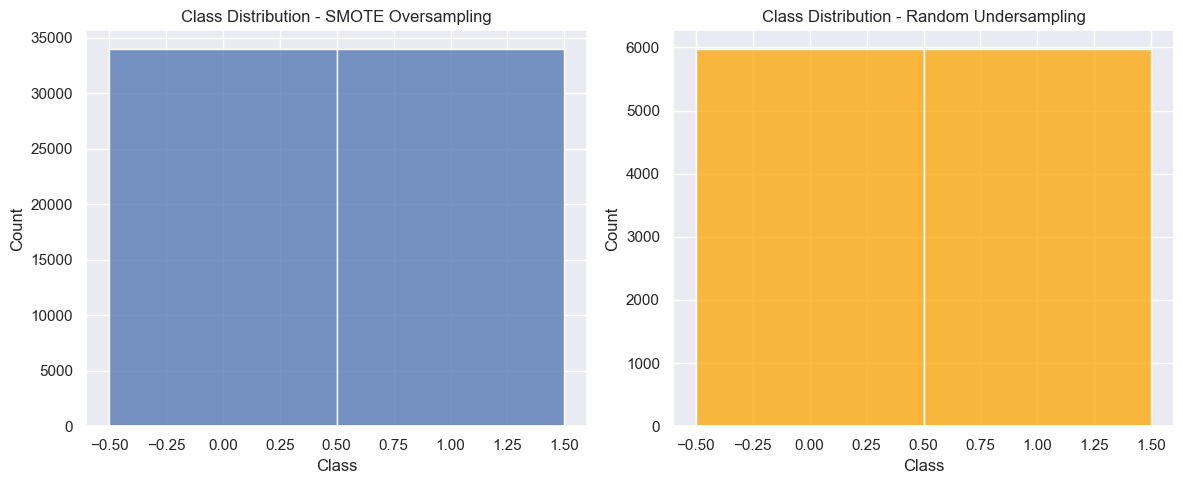

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# SMOTE (oversampling)
sns.histplot(y_train_over, bins=2, discrete=True, ax=axes[0])
axes[0].set_title("Class Distribution - SMOTE Oversampling")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# Random undersampling
sns.histplot(y_train_under, bins=2, discrete=True, ax=axes[1], color="orange")
axes[1].set_title("Class Distribution - Random Undersampling")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

<Axes: >

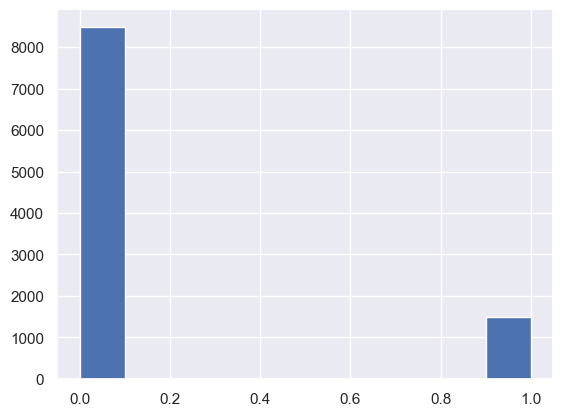

In [36]:
y_test.hist()

#### Model Pipeline

In [37]:
"""
Booking prediction pipeline (no data preparation / scaling / splitting).

Assumes the user has already prepared and scaled X_train, X_test, y_train, y_test.
This file contains the Optuna optimization + training + visualization utilities but
removes any data-prep, scaling, splitting, sampling or target-setting logic.
"""

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm
from IPython import display

import joblib
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)


def create_model_objective(X_train, y_train, model_class, cv=5, metric='f1'):
    """
    Create an Optuna objective function for a given model class.

    NOTE: No preprocessor is used here — it's assumed X_train is already scaled/encoded
    and ready for modeling.
    """
    def objective(trial):
        # Define hyperparameter search space based on model type
        if model_class == LogisticRegression:
            penalty_solver_combo = trial.suggest_categorical('penalty_solver_combo', [
                'none_newton-cg',
                'none_lbfgs',
                'none_sag',
                'none_saga',
                'l1_liblinear',
                'l1_saga',
                'l2_newton-cg',
                'l2_lbfgs',
                'l2_liblinear',
                'l2_sag',
                'l2_saga',
                'elasticnet_saga'
            ])

            penalty_part, solver_part = penalty_solver_combo.split('_')
            penalty = None if penalty_part == 'none' else penalty_part
            solver = solver_part

            params = {
                'penalty': penalty,
                'solver': solver,
                'max_iter': trial.suggest_int('max_iter', 100, 2000),
                'random_state': 42
            }

            if penalty is not None:
                params['C'] = trial.suggest_float('C', 1e-5, 100, log=True)

            if penalty == 'elasticnet':
                params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)

            model = LogisticRegression(**params)

        elif model_class == DecisionTreeClassifier:
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
                'random_state': 42
            }
            model = DecisionTreeClassifier(**params)

        elif model_class == RandomForestClassifier:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                'random_state': 42
            }
            model = RandomForestClassifier(**params)

        elif model_class == XGBClassifier:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'random_state': 42,
                'use_label_encoder': False,
                'eval_metric': 'logloss'
            }
            model = XGBClassifier(**params)

        elif model_class == CatBoostClassifier:
            params = {
                'iterations': trial.suggest_int('iterations', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'depth': trial.suggest_int('depth', 4, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 100, log=True),
                'random_strength': trial.suggest_float('random_strength', 0.1, 10),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
                'random_state': 42,
                'verbose': 0
            }
            model = CatBoostClassifier(**params)

        elif model_class == GaussianNB:
            params = {
                'var_smoothing': trial.suggest_float('var_smoothing', 1e-10, 1e-5, log=True)
            }
            model = GaussianNB(**params)

        elif model_class == SVC:
            params = {
                'C': trial.suggest_float('C', 1e-3, 100, log=True),
                'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
                'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
                'probability': True,
                'random_state': 42
            }
            model = SVC(**params)

        elif model_class == MLPClassifier:
            params = {
                'hidden_layer_sizes': (trial.suggest_int('hidden_layer_size', 50, 300),),
                'activation': trial.suggest_categorical('activation', ['tanh', 'relu']),
                'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
                'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
                'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
                'max_iter': trial.suggest_int('max_iter', 200, 2000),
                'random_state': 42
            }
            model = MLPClassifier(**params)

        else:
            raise ValueError(f"Model class {model_class.__name__} not supported")

        # Cross-validation (no pipeline / preprocessor)
        cv_obj = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

        try:
            scores = cross_val_score(model, X_train, y_train, cv=cv_obj, scoring=metric, error_score='raise')
            return scores.mean()
        except Exception as e:
            print(f"Error during cross-validation: {e}")
            return float('-inf')

    return objective


def optimize_model_with_optuna(X_train, y_train, model_class, n_trials=50, timeout=600, cv=5, metric='f1'):
    """
    Optimize a model's hyperparameters using Optuna. Assumes X_train/y_train are ready.
    """
    objective = create_model_objective(X_train, y_train, model_class, cv, metric)
    study = optuna.create_study(direction='maximize')

    print(f"Optimizing {model_class.__name__} with {n_trials} trials...")

    with tqdm(total=n_trials, desc=f"Optimizing {model_class.__name__}") as pbar:
        def update_progress_bar(study, trial):
            pbar.update(1)
            if study.best_value is not None:
                pbar.set_postfix({"Best Score": f"{study.best_value:.4f}"})

        study.optimize(objective, n_trials=n_trials, timeout=timeout, callbacks=[update_progress_bar], catch=(ValueError, TypeError))

    if len(study.trials) == 0 or study.best_params is None:
        print(f"No successful trials for {model_class.__name__}")
        if model_class == LogisticRegression:
            best_params = {'penalty_solver_combo': 'l2_lbfgs', 'max_iter': 1000, 'C': 1.0}
        else:
            best_params = {}
        return best_params, float('-inf'), study

    return study.best_params, study.best_value, study


def train_and_evaluate_optimized_models(X_train, X_test, y_train, y_test, n_trials=50, timeout=600, cv=5, metric='f1'):
    """
    Train and evaluate models after optimizing their hyperparameters with Optuna.

    Assumes X_train and X_test are already preprocessed/scaled/encoded.
    """
    models = {
        'Logistic Regression': LogisticRegression,
        #'Decision Tree': DecisionTreeClassifier,
        'Random Forest': RandomForestClassifier,
        #'XGBoost': XGBClassifier,
        'CatBoost': CatBoostClassifier,
        #'Gaussian NB': GaussianNB,
        #'SVM': SVC,
        #'Neural Network': MLPClassifier
    }

    # Data is assumed ready — no preprocessing step here
    X_train_processed = X_train
    X_test_processed = X_test

    results = {}
    model_performance = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC',
        'Training Time (s)', 'Optimization Time (s)'
    ])

    optimization_studies = {}

    total_models = len(models)
    print(f"\nOptimizing and training {total_models} models:")

    model_pbar = tqdm(total=total_models, desc="Processing models", unit="model")

    for i, (name, model_class) in enumerate(models.items()):
        model_pbar.set_description(f"Processing {name}")

        opt_start_time = time()
        best_params, best_score, study = optimize_model_with_optuna(
            X_train, y_train, model_class, n_trials=n_trials, timeout=timeout, cv=cv, metric=metric
        )
        opt_time = time() - opt_start_time

        optimization_studies[name] = study

        training_start_time = time()

        try:
            # Reconstruct model with best_params
            if model_class == LogisticRegression:
                if 'penalty_solver_combo' in best_params:
                    combo = best_params.pop('penalty_solver_combo')
                    penalty_part, solver_part = combo.split('_')
                    penalty = None if penalty_part == 'none' else penalty_part
                    solver = solver_part
                    params = {'penalty': penalty, 'solver': solver, 'random_state': 42}
                    for key, value in best_params.items():
                        if key == 'l1_ratio' and penalty != 'elasticnet':
                            continue
                        params[key] = value
                    model = model_class(**params)
                else:
                    model = model_class(random_state=42)
            elif model_class == XGBClassifier:
                model = model_class(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_params)
            elif model_class == CatBoostClassifier:
                model = model_class(random_state=42, verbose=0, **best_params)
            elif model_class == GaussianNB:
                model = model_class(**best_params)
            else:
                # For ensembles and others, pass random_state when available
                try:
                    model = model_class(random_state=42, **best_params)
                except TypeError:
                    model = model_class(**best_params)

            model.fit(X_train_processed, y_train)
            training_time = time() - training_start_time

            y_pred = model.predict(X_test_processed)

            if hasattr(model, "predict_proba"):
                try:
                    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
                    roc_auc = roc_auc_score(y_test, y_pred_proba)
                except Exception:
                    y_pred_proba = None
                    roc_auc = None
            else:
                y_pred_proba = None
                roc_auc = None

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            results[name] = {
                'model': model,
                'best_params': best_params,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1': f1,
                'roc_auc': roc_auc,
                'training_time': training_time,
                'optimization_time': opt_time,
                'confusion_matrix': confusion_matrix(y_test, y_pred)
            }

            model_performance.loc[i] = [
                name, acc, prec, rec, f1, roc_auc, training_time, opt_time
            ]

            model_pbar.set_postfix({'F1': f"{f1:.4f}", 'Acc': f"{acc:.4f}", 'Opt. Time': f"{opt_time:.2f}s"})

        except Exception as e:
            print(f"Error training {name} with optimized parameters: {e}")
            model_performance.loc[i] = [name, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, opt_time]

        model_pbar.update(1)

        if i % 2 == 1 or i == total_models - 1:
            temp_df = model_performance.iloc[:i+1].copy()
            temp_df = temp_df.sort_values('F1 Score', ascending=False, na_position='last')
            display.clear_output(wait=True)
            display.display(model_pbar)
            print("\nCurrent Model Rankings (by F1 Score):")
            display.display(temp_df)

    model_pbar.close()

    model_performance = model_performance.dropna(subset=['F1 Score'])
    model_performance = model_performance.sort_values('F1 Score', ascending=False).reset_index(drop=True)

    print("\nAll models optimized and trained (where possible)!")
    if len(model_performance) > 0:
        print(f"Best model: {model_performance.iloc[0]['Model']} (F1={model_performance.iloc[0]['F1 Score']:.4f})")

    return results, model_performance, optimization_studies


# Visualization and utility functions remain largely the same but expect inputs consistent
# with the no-prep flow (i.e., X is the features DataFrame or numpy array already aligned).


def plot_confusion_matrices_grid(results, max_cols=3):
    sorted_models = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)
    n_models = len(sorted_models)
    if n_models == 0:
        print('No results to plot')
        return

    n_cols = min(max_cols, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    for i, (name, result) in enumerate(sorted_models):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]
        cm = result['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{name}\nF1: {result["f1"]:.4f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    for i in range(n_models, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


def plot_roc_curves(results, y_test, models_to_show=5):
    sorted_models = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)
    models_to_plot = []
    for name, result in sorted_models:
        if result['y_pred_proba'] is not None:
            models_to_plot.append((name, result))
            if len(models_to_plot) == models_to_show:
                break

    if not models_to_plot:
        print('No models with probability estimates to plot ROC curves')
        return

    plt.figure(figsize=(10, 8))
    for name, result in models_to_plot:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Top Models')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_training_and_optimization_times(model_performance):
    plot_df = model_performance.copy()
    plot_df['Total Time'] = plot_df['Training Time (s)'] + plot_df['Optimization Time (s)']
    plot_df = plot_df.sort_values('Total Time')

    fig, ax = plt.subplots(figsize=(12, 8))
    models = plot_df['Model']
    opt_times = plot_df['Optimization Time (s)']
    train_times = plot_df['Training Time (s)']

    ax.barh(models, opt_times)
    ax.barh(models, train_times, left=opt_times)
    ax.set_xlabel('Time (seconds)')
    ax.set_title('Model Optimization and Training Times')
    ax.grid(axis='x', alpha=0.3)
    ax.legend(['Optimization Time', 'Training Time'])

    for i, model in enumerate(models):
        opt_time = opt_times.iloc[i]
        train_time = train_times.iloc[i]
        total_time = opt_time + train_time
        ax.text(opt_time/2, i, f"{opt_time:.1f}s", va='center', ha='center')
        ax.text(opt_time + train_time/2, i, f"{train_time:.1f}s", va='center', ha='center')
        ax.text(total_time + 0.5, i, f"Total: {total_time:.1f}s", va='center', ha='left')

    plt.tight_layout()
    plt.show()


def plot_hyperparameter_tuning_results(optimization_studies, metric='f1'):
    models = []
    best_scores = []
    trial_counts = []

    for model_name, study in optimization_studies.items():
        models.append(model_name)
        best_scores.append(study.best_value)
        trial_counts.append(len(study.trials))

    if not models:
        print('No optimization studies to plot')
        return

    sorted_indices = np.argsort(best_scores)[::-1]
    models = [models[i] for i in sorted_indices]
    best_scores = [best_scores[i] for i in sorted_indices]
    trial_counts = [trial_counts[i] for i in sorted_indices]

    fig, ax1 = plt.subplots(figsize=(12, 8))
    bars = ax1.barh(models, best_scores)
    ax1.set_xlabel(f'Best {metric.upper()} Score')
    ax1.set_title(f'Hyperparameter Tuning Results (Best {metric.upper()} Score)')
    ax1.grid(axis='x', alpha=0.3)

    ax2 = ax1.twiny()
    ax2.plot(trial_counts, models, 'o-', color='red', alpha=0.7)
    ax2.set_xlabel('Number of Trials', color='red')
    ax2.tick_params(axis='x', colors='red')

    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, f"{width:.4f}", va='center')

    for i, (count, model) in enumerate(zip(trial_counts, models)):
        ax2.text(count + 0.5, i, f"{count} trials", va='center', color='red')

    plt.tight_layout()
    plt.show()


def save_optimization_results(results, model_performance, optimization_studies, filename='optuna_churn_results'):
    best_params_dict = {model_name: result['best_params'] for model_name, result in results.items()}
    params_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
    params_df.to_csv(f"{filename}_best_params.csv")
    print(f"Best parameters saved to {filename}_best_params.csv")

    model_performance.to_csv(f"{filename}_performance.csv", index=False)
    print(f"Model performance saved to {filename}_performance.csv")

    for model_name, study in optimization_studies.items():
        joblib.dump(study, f"{filename}_{model_name.replace(' ', '_').lower()}_study.pkl")

    print(f"Optuna studies saved to {filename}_[model_name]_study.pkl files")


def plot_feature_importance(results, X, top_n=15):
    tree_based_models = ['Random Forest', 'XGBoost', 'Decision Tree']

    best_tree_model = None
    best_f1 = -1
    for model_name in tree_based_models:
        if model_name in results and results[model_name]['f1'] > best_f1:
            best_tree_model = model_name
            best_f1 = results[model_name]['f1']

    if best_tree_model is None:
        print("No tree-based models found.")
        return

    model = results[best_tree_model]['model']
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print(f"Model {best_tree_model} doesn't have feature importances available.")
        return

    # X can be a DataFrame or numpy array; handle names accordingly
    if hasattr(X, 'columns'):
        feature_names = X.columns
    else:
        feature_names = [f'feature_{i}' for i in range(len(importances))]

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False).head(top_n)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances ({best_tree_model})')
    plt.grid(axis='x', alpha=0.3)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

    plt.tight_layout()
    plt.show()


# Main runner adapted to no-prep workflow

def run_booking_prediction_pipeline_no_prep(X_train, X_test, y_train, y_test, n_trials=50, timeout=600, cv=5, metric='f1'):
    """
    Run the pipeline assuming all data preparation (scaling, encoding, splitting) was already done.

    Parameters:
    - X_train, X_test: preprocessed feature sets (array or DataFrame)
    - y_train, y_test: target vectors
    """
    print("\n=== CHURN PREDICTION PIPELINE (NO PREP) STARTED ===\n")
    print(f"X_train shape: {getattr(X_train, 'shape', None)}")
    print(f"X_test shape: {getattr(X_test, 'shape', None)}")
    print(f"y_train distribution: {pd.Series(y_train).value_counts().to_dict()}")

    print("\n=== MODEL OPTIMIZATION & TRAINING ===")
    results, model_performance, optimization_studies = train_and_evaluate_optimized_models(
        X_train, X_test, y_train, y_test, n_trials=n_trials, timeout=timeout, cv=cv, metric=metric
    )

    print("\n=== VISUALIZATIONS ===")
    plot_model_performance = lambda df: (plt.figure(figsize=(14, 8)), df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].plot(kind='bar', figsize=(14, 8)))

    try:
        # Performance chart
        plot_model_performance(model_performance)
        plt.tight_layout(); plt.show()

        # Confusion matrices
        plot_confusion_matrices_grid(results)

        # ROC curves
        plot_roc_curves(results, y_test)

        # Times
        plot_training_and_optimization_times(model_performance)

        # Feature importance (pass X_train if you want feature names)
        plot_feature_importance(results, X_train)

        # Hyperparameter tuning overview
        plot_hyperparameter_tuning_results(optimization_studies, metric)

    except Exception as e:
        print(f"Error while generating visualizations: {e}")

    save_optimization_results(results, model_performance, optimization_studies)

    if len(model_performance) > 0:
        best_model_name = model_performance.iloc[0]['Model']
        best_model = results[best_model_name]
        print("\n=== PIPELINE COMPLETED ===")
        print(f"Best Model: {best_model_name}")
        print(f"F1 Score: {best_model['f1']:.4f}")
        print(f"Accuracy: {best_model['accuracy']:.4f}")
    else:
        best_model_name = None
        best_model = None
        print("No successful models to report.")

    return results, model_performance, best_model_name, best_model, optimization_studies

We tested various models and the best performing where Random Forest, Logistic Regression and CatBoost, using the under sampling method. However our F1 score is realy bad and therefore we will use feature selection and re evaluate.

In [38]:
# results, model_performance, best_model_name, best_model, optimization_studies = run_booking_prediction_pipeline_no_prep(
#     X_train_under, X_test, y_train_under, y_test,
#     n_trials=50,      # change to 50+ for serious tuning
#     cv=3,
#     metric='f1'
# )

# print("\n=== Summary ===")
# print("Best model:", best_model_name)
# print(model_performance.head())

Testing Random Forest's with different tuning

In [39]:
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, f1_score
# from tqdm import tqdm
# from sklearn.inspection import permutation_importance

# # First, split test data to create a validation set for permutation importance
# X_test_1, X_val, y_test, y_val = train_test_split(
#     X_test_1, y_test, test_size=0.3, stratify=y_test, random_state=42
# )

# # Train Random Forest
# rf = RandomForestClassifier(
#     n_estimators=100,
#     class_weight="balanced",
#     random_state=42,
#     bootstrap=True,
#     oob_score=True
# )
# rf.fit(X_train_1, y_train)

# # Calculate tree weights based on OOB F1 scores
# tree_weights = []

# for i, est in enumerate(tqdm(rf.estimators_, desc="Evaluating trees", unit="tree")):
#     oob_idx = np.where(rf.estimators_samples_[i] == False)[0]
#     if len(oob_idx) == 0:
#         tree_weights.append(0.0)
#         continue
    
#     # Handle both DataFrame and array inputs
#     if hasattr(X_train_1, 'iloc'):
#         # If it's a DataFrame, use iloc
#         X_oob = X_train_1.iloc[oob_idx]
#     else:
#         # If it's a NumPy array, use direct indexing
#         X_oob = X_train_1[oob_idx]
    
#     if hasattr(y_train, 'iloc'):
#         y_oob = y_train.iloc[oob_idx]
#     else:
#         y_oob = y_train[oob_idx]
    
#     preds = est.predict(X_oob)
#     f1 = f1_score(y_oob, preds, average="binary")
#     tree_weights.append(f1)

# tree_weights = np.array(tree_weights)
# # Add a small epsilon to avoid division by zero
# if tree_weights.sum() == 0:
#     tree_weights = np.ones_like(tree_weights) / len(tree_weights)
# else:
#     tree_weights /= tree_weights.sum()

# # Calculate permutation importance on validation set
# result = permutation_importance(
#     rf, X_val, y_val, 
#     scoring="f1", 
#     n_repeats=5,
#     random_state=42,
#     n_jobs=-1
# )
# feature_weights = result.importances_mean
# feature_weights = np.maximum(feature_weights, 0)  # Ensure non-negative
# if feature_weights.sum() > 0:
#     feature_weights /= feature_weights.sum()
# else:
#     feature_weights = np.ones_like(feature_weights) / len(feature_weights)

# # Make predictions using tree weights
# all_probas = []
# for i, est in enumerate(rf.estimators_):
#     proba = est.predict_proba(X_test_1)
#     all_probas.append(proba * tree_weights[i])
    
# weighted_proba = np.sum(all_probas, axis=0)
# y_pred = weighted_proba.argmax(axis=1)

# # Evaluate
# print("Random Forest with Tree Weighting:")
# print(classification_report(y_test, y_pred, digits=3))

# # For comparison, also show standard RF predictions
# std_preds = rf.predict(X_test_1)
# print("\nStandard Random Forest (for comparison):")
# print(classification_report(y_test, std_preds, digits=3))

In [40]:
# from sklearn.metrics import (
#     confusion_matrix,
#     ConfusionMatrixDisplay,
#     roc_curve,
#     auc,
#     RocCurveDisplay
# )

# # Raw confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# labels = rf.classes_ if hasattr(rf, "classes_") else np.unique(np.concatenate([y_test, y_pred]))

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(ax=axes[0], values_format="d")
# axes[0].set_title("Confusion matrix (counts)")

# # Normalized confusion matrix (by true class / rows)
# with np.errstate(all="ignore"):  # avoid warnings if a row sums to 0
#     cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
# cm_norm = np.nan_to_num(cm_norm)  # turn nan -> 0 for display

# disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
# # use values_format='.2f' for normalized floats
# disp_norm.plot(ax=axes[1], values_format=".2f")
# axes[1].set_title("Confusion matrix (normalized by true class)")

# plt.tight_layout()
# plt.show()

# # ---------- ROC curve + AUC ----------
# # Get score for the positive class. Try predict_proba first, fallback to decision_function.
# if hasattr(rf, "predict_proba"):
#     y_score = rf.predict_proba(X_test_1)[:, 1]
# elif hasattr(rf, "decision_function"):
#     y_score = rf.decision_function(X_test_1)
# else:
#     raise RuntimeError("Model has neither predict_proba nor decision_function; cannot compute ROC.")

# fpr, tpr, thresholds = roc_curve(y_test, y_score)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(7, 6))
# plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
# plt.plot([0, 1], [0, 1], linestyle='--', lw=1, label='Random (AUC = 0.5)')
# plt.xlim([-0.01, 1.01])
# plt.ylim([-0.01, 1.01])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# # ---------- (Optional) Print numeric AUC ----------
# print(f"AUC = {roc_auc:.4f}")

In [41]:
import numpy as np
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, f1_score, precision_recall_curve
from tqdm import tqdm
from sklearn.inspection import permutation_importance

# Convert all data to numpy arrays to avoid indexing issues
X_train_np = X_train_1.values if hasattr(X_train_1, 'values') else X_train_1
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
X_test_np = X_test_1.values if hasattr(X_test_1, 'values') else X_test_1
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

# Initialize variables for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []
best_thresholds = []

print("Starting cross-validation...")
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_np, y_train_np)):
    print(f"Processing fold {fold+1}/10")
    
    # Split data for this fold using numpy arrays
    X_fold_train, X_fold_val = X_train_np[train_idx], X_train_np[val_idx]
    y_fold_train, y_fold_val = y_train_np[train_idx], y_train_np[val_idx]
    
    # Train Balanced Random Forest
    brf = BalancedRandomForestClassifier(
        n_estimators=100,
        random_state=42,
        bootstrap=True,
        sampling_strategy='auto',
        replacement=False,
        oob_score=True  # Enable OOB score estimation
    )
    brf.fit(X_fold_train, y_fold_train)
    
    # For BalancedRandomForest, we need a different approach to get OOB samples
    # Let's use a simpler approach: use the OOB score directly or skip tree weighting
    # Since getting individual tree OOB samples is complex, let's skip tree weighting for now
    # and focus on threshold tuning
    
    # Get validation set predictions for threshold tuning
    val_proba = brf.predict_proba(X_fold_val)[:, 1]  # Probability of positive class
    
    # Find optimal threshold for F1 score
    precision, recall, thresholds = precision_recall_curve(y_fold_val, val_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.nanargmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_thresholds.append(best_threshold)
    
    # Make predictions with optimal threshold
    y_pred_val = (val_proba >= best_threshold).astype(int)
    fold_f1 = f1_score(y_fold_val, y_pred_val, average="binary")
    cv_scores.append(fold_f1)
    
    print(f"Fold {fold+1} - Best threshold: {best_threshold:.3f}, F1-score: {fold_f1:.3f}")

print(f"\nCross-validation completed. Average F1-score: {np.mean(cv_scores):.3f}")

# Train final model on all training data
print("\nTraining final model on all training data...")
final_brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    bootstrap=True,
    sampling_strategy='auto',
    replacement=False,
    oob_score=True
)
final_brf.fit(X_train_np, y_train_np)

# Use average threshold from cross-validation
final_threshold = np.mean(best_thresholds)
print(f"Using average optimal threshold: {final_threshold:.3f}")

# Make predictions on test set with optimal threshold
test_proba = final_brf.predict_proba(X_test_np)[:, 1]
y_pred_tuned = (test_proba >= final_threshold).astype(int)

# Evaluate
print("\nEnhanced Balanced Random Forest with Threshold Tuning:")
print(classification_report(y_test_np, y_pred_tuned, digits=3))

# For comparison, show standard predictions
standard_preds = final_brf.predict(X_test_np)
print("\nStandard Balanced Random Forest (for comparison):")
print(classification_report(y_test_np, standard_preds, digits=3))

# Feature importance analysis
print("\nCalculating feature importance...")
# Create a validation set from test data for permutation importance
X_test_temp, X_val_temp, y_test_temp, y_val_temp = train_test_split(
    X_test_np, y_test_np, test_size=0.3, stratify=y_test_np, random_state=42
)

result = permutation_importance(
    final_brf, X_val_temp, y_val_temp, 
    scoring="f1", 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
feature_weights = result.importances_mean
feature_weights = np.maximum(feature_weights, 0)  # Ensure non-negative
if feature_weights.sum() > 0:
    feature_weights /= feature_weights.sum()

print("Top 10 most important features:")
# If we have feature names from the original data
if hasattr(X_train_1, 'columns'):
    feature_names = X_train_1.columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_weights
    })
    print(feature_importance_df.sort_values('importance', ascending=False).head(10))
else:
    # If we don't have feature names
    top_10_idx = np.argsort(feature_weights)[-10:][::-1]
    for i, idx in enumerate(top_10_idx):
        print(f"{i+1}. Feature {idx}: {feature_weights[idx]:.4f}")

# Additional: Try different thresholds to find the best one for the final model
print("\nFinding optimal threshold for final model...")
final_val_proba = final_brf.predict_proba(X_val_temp)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val_temp, final_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.nanargmax(f1_scores)
best_threshold_final = thresholds[best_idx]

print(f"Optimal threshold on validation set: {best_threshold_final:.3f}")
y_pred_final_tuned = (test_proba >= best_threshold_final).astype(int)

print("\nFinal Model with Validation-set Optimized Threshold:")
print(classification_report(y_test_np, y_pred_final_tuned, digits=3))

Starting cross-validation...
Processing fold 1/10
Fold 1 - Best threshold: 0.557, F1-score: 0.409
Processing fold 2/10
Fold 2 - Best threshold: 0.570, F1-score: 0.400
Processing fold 3/10
Fold 3 - Best threshold: 0.575, F1-score: 0.408
Processing fold 4/10
Fold 4 - Best threshold: 0.620, F1-score: 0.440
Processing fold 5/10
Fold 5 - Best threshold: 0.600, F1-score: 0.412
Processing fold 6/10
Fold 6 - Best threshold: 0.560, F1-score: 0.422
Processing fold 7/10
Fold 7 - Best threshold: 0.605, F1-score: 0.416
Processing fold 8/10
Fold 8 - Best threshold: 0.590, F1-score: 0.394
Processing fold 9/10
Fold 9 - Best threshold: 0.550, F1-score: 0.407
Processing fold 10/10
Fold 10 - Best threshold: 0.615, F1-score: 0.397

Cross-validation completed. Average F1-score: 0.411

Training final model on all training data...
Using average optimal threshold: 0.584

Enhanced Balanced Random Forest with Threshold Tuning:
              precision    recall  f1-score   support

           0      0.915     0.

COMPREHENSIVE MODEL EVALUATION
Cross-Validation F1 Scores: [0.40097475 0.40018128 0.39715682 0.39310032 0.39936609]
Mean CV F1 Score: 0.398 (+/- 0.006)
Cross-Validation AUC Scores: [0.76266385 0.7559608  0.74685276 0.75052314 0.75467289]
Mean CV AUC: 0.754 (+/- 0.011)


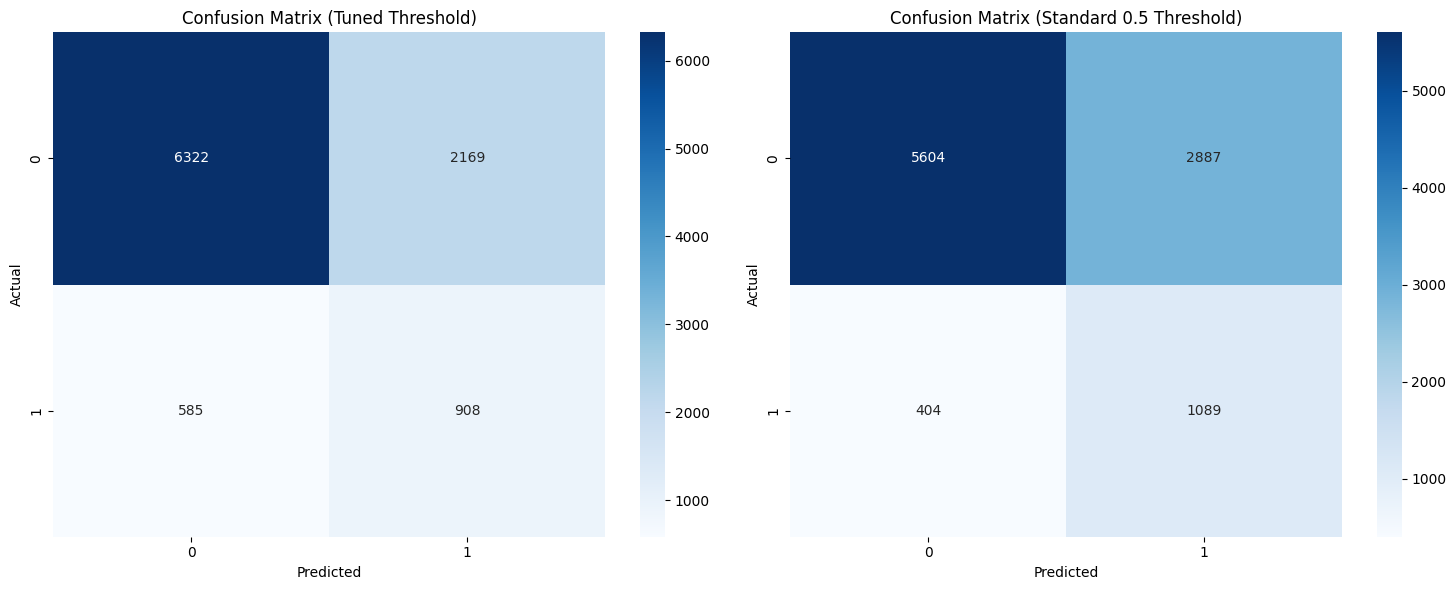

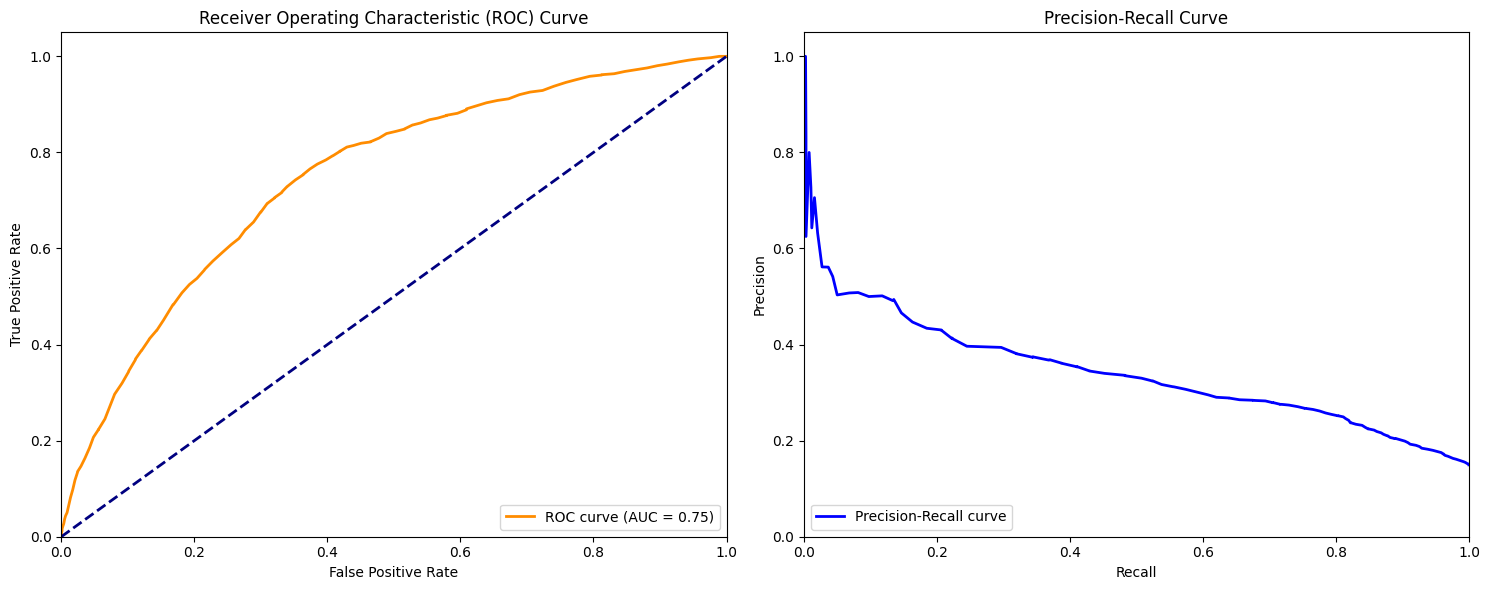

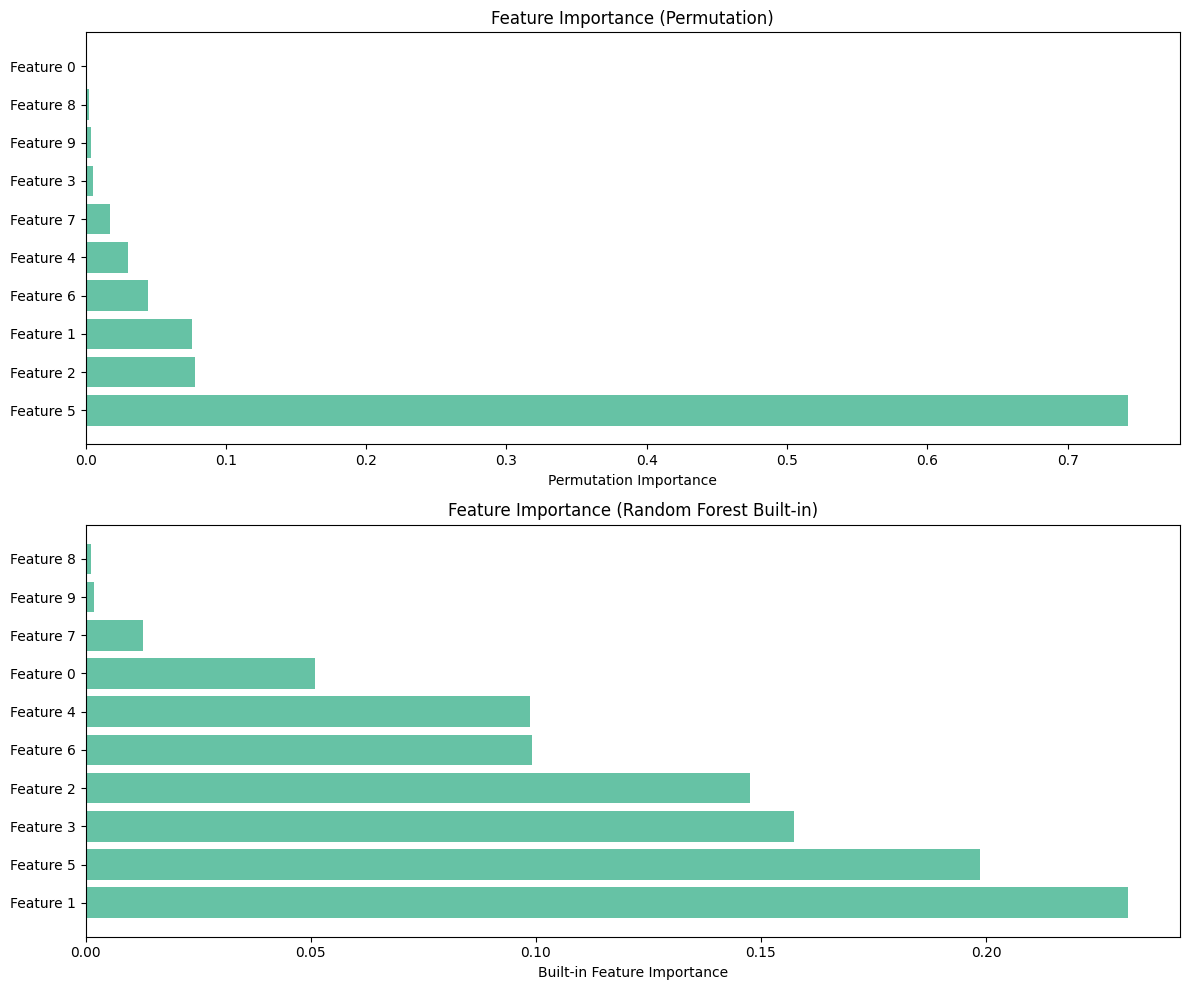

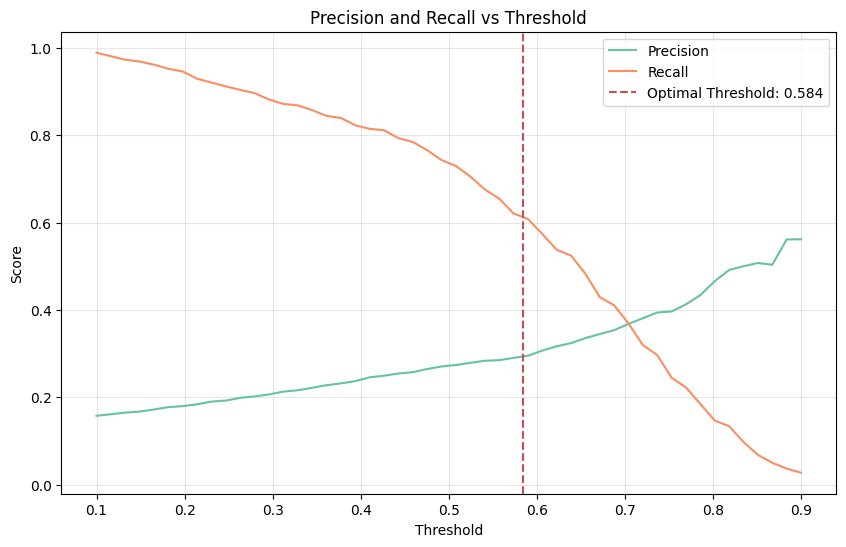


DETAILED PERFORMANCE METRICS
Accuracy: 0.724
Precision: 0.295
Recall: 0.608
F1 Score: 0.397
AUC: 0.747

Comparison with Standard Threshold (0.5):
Accuracy: 0.670
Precision: 0.274
Recall: 0.729
F1 Score: 0.398

All plots and metrics have been saved to the 'model_evaluation_plots' directory.


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np
import os

# Create directory for saving plots if it doesn't exist
os.makedirs('model_evaluation_plots', exist_ok=True)

# Set plot style
plt.style.use('default')
sns.set_palette("Set2")

# 1. Comprehensive Evaluation Metrics
print("=" * 60)
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

# Cross-validation scores
cv_scores_f1 = cross_val_score(final_brf, X_train_np, y_train_np, 
                              cv=StratifiedKFold(n_splits=5), 
                              scoring='f1', n_jobs=-1)
cv_scores_auc = cross_val_score(final_brf, X_train_np, y_train_np, 
                               cv=StratifiedKFold(n_splits=5), 
                               scoring='roc_auc', n_jobs=-1)

print(f"Cross-Validation F1 Scores: {cv_scores_f1}")
print(f"Mean CV F1 Score: {cv_scores_f1.mean():.3f} (+/- {cv_scores_f1.std() * 2:.3f})")
print(f"Cross-Validation AUC Scores: {cv_scores_auc}")
print(f"Mean CV AUC: {cv_scores_auc.mean():.3f} (+/- {cv_scores_auc.std() * 2:.3f})")

# 2. Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion matrix for tuned predictions
cm = confusion_matrix(y_test_np, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Tuned Threshold)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Confusion matrix for standard predictions
cm_standard = confusion_matrix(y_test_np, standard_preds)
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Standard 0.5 Threshold)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('model_evaluation_plots/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. ROC Curve and Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_np, test_proba)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_np, test_proba)
axes[1].plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.savefig('model_evaluation_plots/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Feature Importance Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Get feature names if available
if hasattr(X_train_1, 'columns'):
    feature_names = X_train_1.columns
else:
    feature_names = [f'Feature {i}' for i in range(X_train_np.shape[1])]

# Permutation Importance
sorted_idx = np.argsort(feature_weights)[::-1]
axes[0].barh(range(len(feature_weights)), feature_weights[sorted_idx])
axes[0].set_yticks(range(len(feature_weights)))
axes[0].set_yticklabels([feature_names[i] for i in sorted_idx])
axes[0].set_xlabel('Permutation Importance')
axes[0].set_title('Feature Importance (Permutation)')

# Built-in Feature Importance from Random Forest
importances = final_brf.feature_importances_
sorted_idx_forest = np.argsort(importances)[::-1]
axes[1].barh(range(len(importances)), importances[sorted_idx_forest])
axes[1].set_yticks(range(len(importances)))
axes[1].set_yticklabels([feature_names[i] for i in sorted_idx_forest])
axes[1].set_xlabel('Built-in Feature Importance')
axes[1].set_title('Feature Importance (Random Forest Built-in)')

plt.tight_layout()
plt.savefig('model_evaluation_plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Precision and Recall vs Threshold
plt.figure(figsize=(10, 6))

thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
for threshold in thresholds:
    y_pred = (test_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test_np, y_pred, zero_division=0))
    recalls.append(recall_score(y_test_np, y_pred))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(x=final_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {final_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('model_evaluation_plots/precision_recall_vs_threshold.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Detailed Performance Metrics
print("\n" + "=" * 60)
print("DETAILED PERFORMANCE METRICS")
print("=" * 60)

metrics = {
    "Accuracy": accuracy_score(y_test_np, y_pred_tuned),
    "Precision": precision_score(y_test_np, y_pred_tuned, zero_division=0),
    "Recall": recall_score(y_test_np, y_pred_tuned),
    "F1 Score": f1_score(y_test_np, y_pred_tuned, average="binary"),
    "AUC": roc_auc_score(y_test_np, test_proba)
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Compare with standard threshold
print("\nComparison with Standard Threshold (0.5):")
metrics_standard = {
    "Accuracy": accuracy_score(y_test_np, standard_preds),
    "Precision": precision_score(y_test_np, standard_preds, zero_division=0),
    "Recall": recall_score(y_test_np, standard_preds),
    "F1 Score": f1_score(y_test_np, standard_preds, average="binary")
}

for metric, value in metrics_standard.items():
    print(f"{metric}: {value:.3f}")

# 7. Feature Correlation Heatmap (if feature names available)
if hasattr(X_train_1, 'columns'):
    plt.figure(figsize=(12, 10))
    
    # Create a DataFrame with features and target
    df_plot = pd.DataFrame(X_train_np, columns=feature_names)
    df_plot['target'] = y_train_np
    
    # Calculate correlation matrix
    corr = df_plot.corr()
    
    # Plot heatmap
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('model_evaluation_plots/feature_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

# 8. Save metrics to a text file
with open('model_evaluation_plots/model_performance_metrics.txt', 'w') as f:
    f.write("MODEL PERFORMANCE METRICS\n")
    f.write("=" * 40 + "\n\n")
    
    f.write("Cross-Validation Results:\n")
    f.write(f"Mean CV F1 Score: {cv_scores_f1.mean():.3f} (+/- {cv_scores_f1.std() * 2:.3f})\n")
    f.write(f"Mean CV AUC: {cv_scores_auc.mean():.3f} (+/- {cv_scores_auc.std() * 2:.3f})\n\n")
    
    f.write("Test Set Performance (Tuned Threshold):\n")
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.3f}\n")
    
    f.write("\nTest Set Performance (Standard Threshold):\n")
    for metric, value in metrics_standard.items():
        f.write(f"{metric}: {value:.3f}\n")
    
    f.write("\nTop 10 Most Important Features:\n")
    if hasattr(X_train_1, 'columns'):
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_weights
        })
        top_features = feature_importance_df.sort_values('importance', ascending=False).head(10)
        for i, row in top_features.iterrows():
            f.write(f"{row['feature']}: {row['importance']:.4f}\n")
    else:
        top_10_idx = np.argsort(feature_weights)[-10:][::-1]
        for i, idx in enumerate(top_10_idx):
            f.write(f"Feature {idx}: {feature_weights[idx]:.4f}\n")

print("\nAll plots and metrics have been saved to the 'model_evaluation_plots' directory.")